# Foundations of LLMs

<a href="https://colab.research.google.com/github/khipu-ai/practicals-2025/blob/main/notebooks/Foundations_of_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='#9d9d9d'>
© Deep Learning Indaba 2024. Apache License 2.0.</br></br></font>
<font color='#797979'>
<b>Authors</b>: Jabez Magomere, Harry Mayne, Khalil Mrini, Nabra Rizvi, Doudou Ba, Ruan van der Merwe, Marianne Monteiro, Everlyn Asiko Chimoto.</br>
<b>Reviewers</b>: Seid Muhie Yimam, Foutse Yuehgoh</br>
<b>Edited</b>: Mai Gimenez</br>
</font>

## Introduction

In this tutorial, you'll dive into the core principles of transformers and the cutting-edge technology behind models like GPT. You'll also get hands-on experience training your very own Language Model! Get ready to explore how these impressive AI systems create such realistic and engaging text. Let's embark on this exciting journey together and unlock the secrets of LLMs! 🚀📚


## Choose your own adventure
This tutorial is structured to offer content for everyone. Sections are labelled based on your background so that you can tailor your learning experience to you.

* 🌱 <font color='green'> Beginner: </font> It is my first time being introduced to this work.
* 🪴 <font color='orange'> Intermediate: </font>I have done some basic courses/intros on this topic.
* 🌳 <font color='blue'> Advance: </font>I work in this area/topic daily.

There are a mix of examples and exercises thought the tutorial.
* Exercises are marked with 🛠️
* Examples and code needed to execute the tutorial are marked with ⚙️


### Prerequisites
There are some prerequisites that the attendants are already familiar with.

* Basic knowledge of Deep Learning.
* Familiarity with Natural Language Processing (NLP).
* Understanding of sequence-to-sequence models.
* Basic understanding of Linear Algebra.

## What would you learn

### Topics

- <font color='green'> 🌱 Intoduction: demo using Hugging Face</font>
- <font color='orange'> 🪴 Understanding the attention mechanism</font>
- <font color='orange'> 🪴 Transformer Architecture</font>
- <font color='orange'> 🪴 Training objective </font>
- <font color='blue'> 🌳 Training your own LLM from scratch</font>

- <font color='green'> 🌱 Finetuning an LLM for Text Classification</font>

Level: <font color='green'>Beginner</font>, <font color='orange'>Intermediate</font>, <font color='blue'>Advanced</font>

### Aims/Learning Objectives:

* Understand the idea behind [Attention](https://arxiv.org/abs/1706.03762) and why it is used.
* Present and describe the fundamental building blocks of the [Transformer Architecture](https://arxiv.org/abs/1706.03762) and intuition on such an architecture design.
* Build and train a simple Shakespeare-inspired LLM.



## <font color='orange'> ⚠️ **Before you start:** </font>

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type", and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.


## <font color='green'> 🌱 Beginner: </font> Demo using Hugging Face

We're thrilled to have you on board! 🎉 Before we dive into the hands-on part of our journey, let's take a quick detour into the fascinating world of [Hugging Face](https://huggingface.co/)—an incredible open-source platform for building and deploying cutting-edge language models. 🌐

As a sneak peek into what we'll be creating today, we'll start by loading a *small* large language model (*in comparison to today's models) and prompting it with a simple instruction. This will give you a feel for how to interact with these powerful libraries. 💡 Get ready to unlock the potential of language models with just a few lines of code!


<img src="https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo.png" width="10%">


[Hugging Face](https://huggingface.co/) is a startup founded in 2016 and, in their own words: "are on a mission to democratize good machine learning, one commit at a time." Currently they are a treasure trove for tools to work on and with Large Language Model (LLMs).

They have developed various open-source packages and allow users to easily interact with a large corpus of pretrained transformer models (across all modalities) and datasets to train or fine-tune pre-trained transformers. Their software is used widely in industry and research. For more details on them and usage, refer to [the 2022 attention and transformer practical](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/attention_and_transformers.ipynb#scrollTo=qFBw8kRx-4Mk).


### Installations, imports and helper functions

These cells need to be run to get the demo working

In [ ]:
#@title ⚙️ Installations and imports
# Install necessary libraries for deep learning, NLP, and plotting
!pip install transformers datasets  # Transformers and datasets libraries for NLP tasks
!pip install seaborn umap-learn     # Seaborn for plotting, UMAP for dimensionality reduction
!pip install livelossplot           # LiveLossPlot for tracking model training progress
!pip install -q transformers[torch] # Transformers with PyTorch backend
!pip install -q peft                # Parameter-Efficient Fine-Tuning library
!pip install accelerate -U          # Accelerate library for performance

# Install utilities for debugging and console output formatting
!pip install -q ipdb                # Interactive Python Debugger
!pip install -q colorama            # Colored terminal text output

# Import system and math utilities
import os
import math
import urllib.request

# Check for connected accelerators (GPU or TPU) and set up accordingly
if os.environ.get("COLAB_GPU") and int(os.environ["COLAB_GPU"]) > 0:
    print("A GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")

# Avoid GPU memory allocation to be done by JAX
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

# Import libraries for JAX-based deep learning
import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax

# Import NLP and model-related libraries
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets
import peft

# Import image processing and plotting libraries
from PIL import Image
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import additional utilities for working with text and models
import torch
import torchvision
import itertools
import random
import copy

# Download an example image to use in the notebook
urllib.request.urlretrieve(
    "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
    "cat.png",
)

# Import libraries for NLP preprocessing and working with pre-trained models
import gensim
from nltk.data import find
import nltk
nltk.download("word2vec_sample")

# Import Hugging Face tools and IPython widgets
import huggingface_hub
import ipywidgets as widgets
from IPython.display import display
import colorama

# Set Matplotlib to output SVG format for better quality plots
%config InlineBackend.figure_format = 'svg'



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 903.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 211.5/211.5 MB 15.5 MB/s eta 0:00:01

In [ ]:
#@title ⚙️ Helper Plotting Functions.l

def plot_position_encodings(P, max_tokens, d_model):
    """
    Plots the position encodings matrix.

    Args:
        P: Position encoding matrix (2D array).
        max_tokens: Maximum number of tokens (rows) to plot.
        d_model: Dimensionality of the model (columns) to plot.
    """

    # Set up the plot size based on the number of tokens and model dimensions
    plt.figure(figsize=(20, np.min([8, max_tokens])))

    # Plot the position encoding matrix with a color map for better visualization
    im = plt.imshow(P, aspect="auto", cmap="Blues_r")

    # Add a color bar to indicate the encoding values
    plt.colorbar(im, cmap="blue")

    # Show embedding indices as ticks if the dimensionality is small
    if d_model <= 64:
        plt.xticks(range(d_model))

    # Show position indices as ticks if the number of tokens is small
    if max_tokens <= 32:
        plt.yticks(range(max_tokens))

    # Label the axes
    plt.xlabel("Embedding index")
    plt.ylabel("Position index")

    # Display the plot
    plt.show()


def plot_image_patches(patches):
    """
    Function that takes in a list of patches and plots them.

    Args:
        patches: A list or array of image patches to plot.
    """

    # Set up the figure for plotting patches
    fig = plt.figure(figsize=(25, 25))

    # Create a subplot for each patch and display it
    axes = []
    for a in range(patches.shape[1]):
        axes.append(fig.add_subplot(1, patches.shape[1], a + 1))
        plt.imshow(patches[0][a])

    # Adjust layout to prevent overlap and display the plot
    fig.tight_layout()
    plt.show()


def plot_projected_embeddings(embeddings, labels):
    """
    Projects high-dimensional embeddings onto 2D space and plots them.

    Args:
        embeddings: High-dimensional embedding vectors to project.
        labels: Labels corresponding to each embedding for coloring in the plot.
    """

    # Import UMAP and Seaborn for dimensionality reduction and plotting
    import umap
    import seaborn as sns

    # Reduce the dimensionality of the embeddings to 2D using UMAP
    projected_embeddings = umap.UMAP().fit_transform(embeddings)

    # Plot the 2D projections with labels using Seaborn for better aesthetics
    plt.figure(figsize=(15, 8))
    plt.title("Projected text embeddings")
    sns.scatterplot(
        x=projected_embeddings[:, 0], y=projected_embeddings[:, 1], hue=labels
    )

    # Display the plot
    plt.show()


def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """
    Plots an attention weight matrix with custom axis ticks.

    Args:
        weight_matrix: The attention weight matrix to plot.
        x_ticks: Labels for the x-axis (typically the query tokens).
        y_ticks: Labels for the y-axis (typically the key tokens).
    """

    # Set up the plot size
    plt.figure(figsize=(15, 7))

    # Plot the attention weight matrix as a heatmap
    ax = sns.heatmap(weight_matrix, cmap="Blues")

    # Set custom ticks on the x and y axes
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)

    # Label the plot
    plt.title("Attention matrix")
    plt.xlabel("Attention score")

    # Display the plot
    plt.show()


In [ ]:
#@title ⚙️ Helper Text Processing Functions.

def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(jnp.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = jnp.array(output)
    del model  # free up space again
    return embeddings, words_pass


def remove_punctuation(text):
    """Function that takes in a string and removes all punctuation."""
    import re

    text = re.sub(r"[^\w\s]", "", text)
    return text

def print_sample(prompt: str, sample: str):
  """Function that takes in a prompt instruction and model response and
  prints them out in different colors to show a distinction"""
  print(colorama.Fore.MAGENTA + prompt, end="")
  print(colorama.Fore.BLUE + sample)
  print(colorama.Fore.RESET)

### LLM Demo: Load and interact with an LLM model from Hugging Face

Let's dive into how simple it is to load and interact with a model from Hugging Face!

For this tutorial, we've pre-configured two model options:

- **`gpt-neo-125M`**: A smaller model with 125 million parameters. It's faster and uses less memory—perfect for getting started! We recommend trying this one first.
- **`gpt2-medium`**: A larger model with 355 million parameters for more advanced use.

If you want to switch models, just restart the Colab kernel and update the model name in the cell below.

**Note**: The steps we're about to show work not only for these models but also for [all models](https://huggingface.co/models?pipeline_tag=text-generation) on Hugging Face that support text generation pipelines.

In [ ]:
#@markdown In this colab we print prompts in <font color='HotPink'><b>pink</b></font> and samples generated from a model in <font color='blue'><b>blue</b></font>  like in the example below:

print_sample(prompt='My fake prompt', sample=' is awesome!')

My fake prompt is awesome!



In [ ]:
#@title ⚙️ Demo
#@markdown Datasets Package - <font color='blue'>`Beginner`</font>

# Set the model name to "EleutherAI/gpt-neo-125M" (this can be changed via the dropdown options)
MODEL_NAME = "gpt2-medium"  # @param ["gpt2-medium", "EleutherAI/gpt-neo-125M"]

# Define the prompt for the text generation model
test_prompt = 'What is love?'  # @param {type: "string"}

# Create a text generation pipeline using the specified model
generator = transformers.pipeline('text-generation',
                                  model=MODEL_NAME)

# Generate text based on the provided prompt
# 'do_sample=True' enables sampling to introduce randomness in generation, and 'min_length=30' ensures at least 30 tokens are generated
model_output = generator(test_prompt, do_sample=True, min_length=30)

# Print the generated text sample, removing the original prompt from the output
print_sample(test_prompt, model_output[0]['generated_text'].split(test_prompt)[1].rstrip())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/gpt2-medium/fc5a354a19255ad494f3d71549390baca1ccf61d1d822b9408971705c687c9cd?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1740930260&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MDkzMDI2MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9ncHQyLW1lZGl1bS9mYzVhMzU0YTE5MjU1YWQ0OTRmM2Q3MTU0OTM5MGJhY2ExY2NmNjFkMWQ4MjJiOTQwODk3MTcwNWM2ODdjOWNkP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=pn0ceeO7PPULCDPOCI02ye7N2azclSB0FcVgvveJWv9zYDSocasC0jH-cghYdfn5sLX8rC4sVoEL6N9ckw-c4RndJqh%7EshY3TJB0JqslBhCnaPiRVu6KLcGpU6DQDqqMX8bHMV8e5TU3uiEYXVQMG%7ETY9NpGezKMBoj45A5-CtI4lCIYb08UmSso5Ln%7E0g9Cu-aQqjq2nds2CBy-yP4AngETIhhmPIRX2AOZl3ERRwxhIcc%7EQOECHHM9V9PMO-p61uejjXqkLx3NwDtyoabixEEKkZwznQPyAGd1Or7q%7Ek2DbaibMHu2CQXkv2MhR6HvVg-6CKT-Gs5%7E%7EerxQqEEKw__&Key-Pair-Id=K3RPWS32NSSJCE: [SSL: DECRYPTION_FAILED_OR_BAD_RECO

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is love? An American woman asks

a few well-meaning words of advice from a Chinese doctor in a video message on the day

followers. The doctor is apparently married, has many children, and, of course,



**💡 Tip:** Try running the code above with different prompts or with the same prompt more than once!

**🤔 Discussion:** Why do you think the generated text changes every time, even with the same prompt? Write your response in the input field below and discuss with your neighbour.

In [ ]:
#@title ⚙️ Customize your generation pipeline
def get_model_and_tokenizer(model_name: str):
  """Given a model name get the model and the tokenizer.

  Args:
    model_name: name of the model to load.

  Returns
    model: The language model we’ll use to generate text
    tokenizer: The tokenizer that converts text into a format the model understands
  """
  match model_name:
    case 'gpt2-medium':
      # Load the GPT-2 tokenizer and model
      tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_name)
      model = transformers.GPT2LMHeadModel.from_pretrained(model_name)
    case 'EleutherAI/gpt-neo-125M':
      tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
      model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
    case _:
      raise NotImplementedError(f'Model {model_name} is not recognised')
  # If a GPU is available, move the model to the GPU for faster processing
  if torch.cuda.is_available():
    model = model.to("cuda")

  # Set the padding token ID to be the same as the end-of-sequence token ID
  tokenizer.pad_token_id = tokenizer.eos_token_id

  return model, tokenizer

def run_sample(
    model_name: str,
    prompt: str,
    seed: int | None = None,
    temperature: float = 0.6,
    top_p: float = 0.9,
    max_new_tokens: int = 64,
) -> str:
    """Run a model and generate a sample from a prompt

    This function generates text based on a given prompt using a language model,
    with options to control randomness, the number of tokens generated, and reproducibility.

    Args:
      model_name: Na
      prompt: The text prompt we'll give to the model to start the text generation
      seed: A number to make the results predictable each time (optional)
      temperature: Controls how random the model’s output is; lower values make it more focused
      top-p: Controls how much of the most likely words are considered; higher values consider more options
      max_new_tokens: The maximum number of words or tokens the model model generate after seeing the prompt

    Returns:
      Text generated
    """
    model, tokenizer = get_model_and_tokenizer(model_name)
    # Convert the prompt text into tokens that the model can process
    inputs = tokenizer(prompt, return_tensors="pt")

    # Extract the tokens (input IDs) and attention mask (to focus on important parts) from the inputs
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Move the tokens and attention mask to the same device as the model (like a GPU if available)
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    # Set up how we want the model to generate text
    generation_config = transformers.GenerationConfig(
        do_sample=True,  # Allow the model to add some randomness to its text generation
        temperature=temperature,  # Adjust how random the output is; lower means more focused
        top_p=top_p,  # Consider the most likely words that make up the top 90% of possibilities
        pad_token_id=tokenizer.pad_token_id,  # Use the token ID that represents padding (extra space)
        top_k=0,  # We're not limiting to the top-k words, so we set this to 0
    )

    # If a seed is provided, set it so that the results are repeatable (same output each time)
    if seed is not None:
        torch.manual_seed(seed)

    # Generate text using the model with the settings we defined
    generation_output = model.generate(
        input_ids=input_ids,  # Provide the input tokens to the model
        attention_mask=attention_mask,  # Provide the attention mask to help the model focus
        return_dict_in_generate=True,  # Ask the model to return detailed information
        output_scores=True,  # Include the scores (confidence levels) for the generated tokens
        max_new_tokens=max_new_tokens,  # Set the maximum number of tokens to generate
        generation_config=generation_config,  # Apply our custom text generation settings
    )

    # Make sure only one sequence (output) is generated, to keep things simple
    assert len(generation_output.sequences) == 1

    # Get the generated sequence of tokens
    output_sequence = generation_output.sequences[0]

    # Convert the generated tokens back into readable text
    output_string = tokenizer.decode(output_sequence)

    # Print the prompt and the generated response
    print_sample(prompt, output_string)

    # Return the generated text response
    return output_string

In [ ]:
_ = run_sample(model_name=MODEL_NAME, prompt="What is love?", temperature = 0.5, seed=2)

What is love?What is love?

Love is the gift of the Spirit.

Love is the gift of the Holy Spirit.

Love is the gift of the Father and of the Son and of the Holy Spirit.

Love is the gift of the Holy Spirit.

Love is the gift of the Father and of the Son



Pretty amazing, right? 🤩 Try playing around with the **prompt**, **temperature** and **seed** values above and see what different outputs you get. What do you notice when you increase the temperature? While this might have been mind-blowing back in 2021, by now, most of you have likely interacted with large language models in some way. Today, we're going to take things a step further by training our own **Shakespeare-inspired LLM**. This will give us a hands-on understanding of how these language models work under the hood.

But before we jump into training, let’s first build a solid understanding of what **Large Language Models** are and the key **Machine Learning** concepts that make this groundbreaking technology possible. At the heart of today’s state-of-the-art (SoTA) LLMs are the **Attention Mechanism** and the **Transformer Architecture**. We’ll explore these essential concepts in the upcoming sections of this tutorial. 🚀💡

## <font color='orange'> 🪴 Intermediate: </font> Understanding the attention mechanism </font>


The attention mechanism focuses on an image or sentence's most essential parts. Some people like the metaphor that the attention mechanism mimics how humans look at an image or read a sentence.


### Attention in images

Let us take the image of the dog in human clothes below (image and example [source](https://lilianweng.github.io/posts/2018-06-24-attention/)). When paying *attention* to the red blocks of pixels, we will say that the yellow block of pointy ears is something we expected (correlated) but that the grey blocks of human clothes are unexpected (uncorrelated). This is *based on what we have seen in the past* when looking at pictures of dogs, precisely one of a Shiba Inu.

<img src="https://drive.google.com/uc?export=view&id=1iEU7Cph2D2PCXp3YEHj30-EndhHAeB5T" alt="drawing" width="450"/>

Assume we want to identify the dog breed in this image. We will pay more **attention** to the pixels where the ears, eyes, and snout are. Those are the yellow and red blocks, and all the information there will show us that this is a Shiba Inu. We usually ignore the snow in the background and the human clothing for this task.

Alternatively, we want to identify where this picture was taken. In that case, we begin looking at the background and subconsciously ignore the dog pixels because they are irrelevant to the current task.



### Attention in text

The same thing happens when we read. In order to understand the entire sentence, we will learn to correlate and *attend to* certain words based on the context of the entire sentence.

<img src="https://drive.google.com/uc?export=view&id=1j23kcfu_c3wINU6DUvxzMYNmp4alhHc9" alt="drawing" width="350"/>

 For instance, in the first sentence in the image above, when looking at the word "coding", we pay more attention to the word "Apple" and "computer" because we know that when we speak about coding, "Apple" is actually referring to the company. However, in the second sentence, we realise we should not consider " apple " when looking at "code" because given the context of the rest of the sentence, we know that this apple is referring to an actual apple and not a computer.

We can build better models by developing mechanisms that mimic attention. It will enable our models to learn better representations of our input data by contextualising what it knows about some parts of the input based on other parts. In the following sections, we will explore the mechanisms that enable us to train deep learning models to attend to input data in the context of other input data.



### 🌱 Intuition to undestand attention

Imagine attention as a mechanism that allows a neural network to focus more on certain parts of data. By doing this, the network can enhance its grasp of the problem it's working on, updating its understanding or representations accordingly.


###🪴 Understanding Attention in Simple Terms



One way to implement attention in neural networks is by representing each word (or even parts of a word) as a vector.

So, what's a vector? A vector is simply an array of numbers (called real-valued numbers) that can have different lengths. Think of it like a list of values that describe certain properties of a word. These vectors allow us to measure how similar two words are to each other. One common way to measure this similarity is by calculating something called the **dot product**.

The result of this similarity calculation is what we refer to as **attention.** This attention value helps the model decide how much one word should influence the representation of another word.

In simpler terms, if two words have similar vector representations, it means they’re likely related or important to each other. Because of this relationship, they affect each other’s representations inside the neural network, allowing the model to understand the context better. 🎯

To illustrate how the dot product can create meaningful attention weights, we'll use pre-trained [word2vec](https://jalammar.github.io/illustrated-word2vec/) embeddings. These word2vec embeddings are generated by a neural network that learned to create similar embeddings for words with similar meanings.

By calculating the matrix of dot products between all vectors, we get an attention matrix. This will indicate which words are correlated and therefore should "attend" to each other.

[1] You can find more details about how this is done for LLMs in the "Building Your Own LLM" session.

In [ ]:
#@title ⚒️ Code task:  Complete the dot product attention function below.
def dot_product_attention(hidden_states, previous_state):
    """
    Calculate the dot product between the hidden states and previous states.

    Args:
        hidden_states: A tensor with shape [T_hidden, dm]
        previous_state: A tensor with shape [T_previous, dm]
    """

    # Hint: To calculate the attention scores, think about how you can use the `previous_state` vector
    # and the `hidden_states` matrix. You want to find out how much each element in `previous_state`
    # should "pay attention" to each element in `hidden_states`. Remember that in matrix multiplication,
    # you can find the relationship between two sets of vectors by multiplying one by the transpose of the other.
    # Hint: Use `jnp.matmul` to perform the matrix multiplication between `previous_state` and the
    # transpose of `hidden_states` (`hidden_states.T`).
    scores = ...  # FINISH ME

    # Hint: Now that you have the scores, you need to convert them into probabilities.
    # A softmax function is typically used in attention mechanisms to turn raw scores into probabilities
    # that sum to 1. This will help in determining how much focus should be placed on each hidden state.
    # Hint: Use `jax.nn.softmax` to apply the softmax function to `scores`.
    w_n = ...  # FINISH ME

    # Multiply the weights by the hidden states to get the context vector
    # Hint: Use `jnp.matmul` again to multiply the attention weights `w_n` by `hidden_states`
    # to get the context vector.
    c_t = jnp.matmul(w_n, hidden_states)

    return w_n, c_t

In [ ]:
#@title ⚙️ Test your solution
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [2, 2])

try:
  w_n, c_t = dot_product_attention(x, x)

  w_n_correct = jnp.array([[0.9567678, 0.04323225], [0.00121029, 0.99878967]])
  c_t_correct = jnp.array([[0.11144122, 0.95290256], [-1.5571996, -1.5321486]])
  assert jnp.allclose(w_n_correct, w_n), "w_n is not calculated correctly"
  assert jnp.allclose(c_t_correct, c_t), "c_t is not calculated correctly"

  print("It seems correct. Look at the answer below to compare methods.")
except:
  print("It looks like the function isn't fully implemented yet. Try modifying it.")

It looks like the function isn't fully implemented yet. Try modifying it.


In [ ]:
# @title ✅ Solution to the task (Try not to peek until you've given it a good try!')
def dot_product_attention(hidden_states, previous_state):
    # Calculate the attention scores:
    # Multiply the previous state vector by the transpose of the hidden states matrix.
    # This gives us a matrix of scores that show how much attention each element in the previous state
    # should pay to each element in the hidden states.
    # The result is a matrix of shape [T, N], where:
    # T is the number of elements in the hidden states,
    # N is the number of elements in the previous state.
    scores = jnp.matmul(previous_state, hidden_states.T)

    # Apply the softmax function to the scores to convert them into probabilities.
    # This normalizes the scores so that they sum up to 1 for each element,
    # allowing us to interpret them as how much attention should be given to each hidden state.
    w_n = jax.nn.softmax(scores)

    # Calculate the context vector (c_t):
    # Multiply the attention weights (w_n) by the hidden states.
    # This combines the hidden states based on how much attention each one deserves,
    # resulting in a new vector that represents the weighted sum of the hidden states.
    # The resulting shape is [T, d], where:
    # T is the number of elements in the previous state,
    # d is the dimension of the hidden states.
    c_t = jnp.matmul(w_n, hidden_states)

    # Return the attention weights and the context vector.
    return w_n, c_t

<ipython-input-4-5925ce255053>:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(jnp.array(model.word_vec(word)))


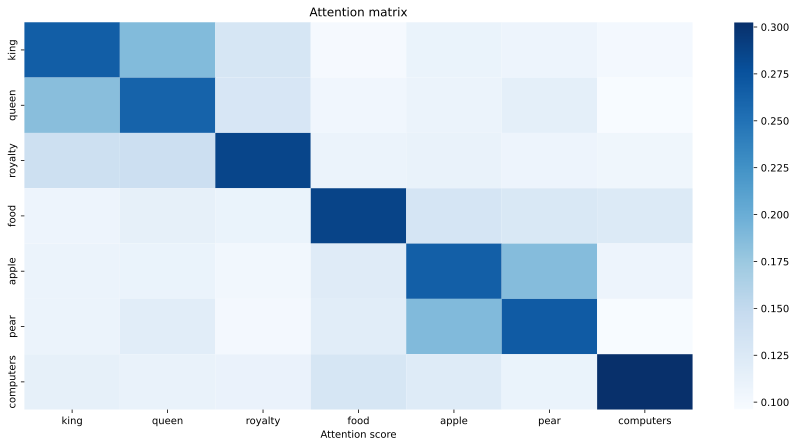

In [ ]:
#@title Plot the similarities between words.

# When changing these words, note that if the word is not in the original
# training corpus it will not be shown in the weight matrix plot.
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

Looking at the matrix,  we can see which words have similar meanings. The "royal" group of words have higher attention scores with each other than the "food" words, which all attend to one another. We also see that "computers" have very low attention scores for all of them, which shows that they are neither very related to "royal" or "food" words.  



**Note**: Dot product is only one of the ways to implement the scoring function for attention mechanisms, there is a more extensive list in this [blog](https://lilianweng.github.io/posts/2018-06-24-attention/#summary) post by Dr Lilian Weng.

More resources:
*  [A basic encoder-decoder model for machine translation](https://www.youtube.com/watch?v=gHk2IWivt_8&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=1)
*  [Training and loss for encoder-decoder models](https://www.youtube.com/watch?v=aBZUTuT1Izs&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=2)
* [Basic attention](https://www.youtube.com/watch?v=BSSoEtv5jvQ&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=6)


#### 🛠️ Group task

<ul>
  <li><font color='784fb7'>Play with the word selections above. See if you can find word combinations whose attention values seem counter-intuitive. Think of possible explanations. Which sense of a word did the attention scores capture?</font>
  <li><font color='784fb7'>Ask your friend if they found examples.</font>
</ul>




### 🪴 Sequence to sequence attenion mechanisms



The first attention mechanisms were used in sequence-to-sequence models. These models were usually RNN encoder and decoder structures. The input sequence was processed sequentially by an RNN, encoding the sequence in a single context vector, which is then fed into another RNN that generates a new sequence. Below is an example of this ([source](https://lilianweng.github.io/posts/2018-06-24-attention/)).


<img src="https://drive.google.com/uc?export=view&id=1FKfaArN1rsLjzVWaJGpMLEcxEshSLXd6" alt="drawing" width="600"/>

Since there is only one context vector, it is challenging to for the encoder to represent long sequences and information typically gets lost. The attention mechanism introduced in [Bahdanau et al., 2015](https://arxiv.org/pdf/1409.0473.pdf) was proposed to solve this.

Here, instead of relying on one static context vector, which is also only used once in the decoding process, let us provide information on the entire input sequence at every decoding step using a dynamic context vector. By doing this, the decoder can access a larger "bank" of memory and attend to the input's required information based on the current decoder RNN output state, $s_t$. This is shown below.

<img src="https://drive.google.com/uc?export=view&id=1fB5KObXcKo5x35xlIDIcjHTq1q75ejIB" alt="drawing" width="600"/>

In deep learning, attention can be interpreted as a vector of "importance." To predict or infer one element, such as a pixel in an image or a word in a sentence, we estimate how strongly it is correlated with, or "attends to," other elements using the attention vector/weights. These attention weights are then used to generate a new weighted sum of the remaining elements, which represents the target [(source)](https://lilianweng.github.io/posts/2018-06-24-attention/).


This, usually, consists of three steps for each decoding step $t$:

1. Calculate the score (importance) for each $h_n$, given $s_{t-1}$ and use the softmax function to transform this into an attention vector, $w_{n}$.
  - $\text{score} = a(s_{t−1}, h_{n})$, where $a$ can be any differentiable function, such as the dot product.
  - $w_{n} = \frac{\exp \left\{a\left(s_{t-1}, h_{n}\right)\right\}}{\sum_{j=1}^{N} \exp \left\{a\left(s_{t-1}, h_{j}\right)\right\}}$, where we use the softmax function to transform the raw scores to relative attention weights.
2. Generate the final context vector, $c_t$, by summing the products of the attention weights and the encoder context vectors.
  - $c_t=\sum_{n=1}^{N} w_n h_{n}$
3. Generate the subsequent decoder state $s_{t+1}$ by combining the current decoder state, $s_t$, with the context vector, $c_t$, via some function, $f$.

  - $s_{t+1} = f\left ( c_t, s_t \right)$

  In Bahdanau et al., 2015, $f$ was a learned feedforward layer taking in the concatenated vector $[c_t; s_t]$, with $a(s_{t−1}, h_{n})$ being the dot product.
  
Next, let us build up this attention schema, as used in the transformer architecture. We've already calcualed simple dot product attention, where the score was given by $a(s_{t-1}, h_n)=s_{t-1} h_n^\top$ and we're going to use the same idea again.

###🪴 Attention mechanisms in transformers

Self-attention and multi-head attention (MHA) are fundamental components of the transformer architecture. In this section, we'll thoroughly explain the intuition behind these concepts and their implementation. Later, in the **Transformers** section, you'll learn how these attention mechanisms are used to create a sequence-to-sequence model that relies entirely on attention.

In [ ]:
#@title ⚙️ Embed sentences
#@markdown As we move forward, we'll represent sentences by breaking them down into individual words and encoding each word using the word2vec model discussed earlier. In the Transformers section, we'll explore in more detail how input sequences are transformed into a series of vectors.

def embed_sentence(sentence: str) -> jnp.array:
    """Embed a sentence using word2vec; for example use cases only."""
    # clean sentence (not necessary if using a proper LLM tokenizer)
    sentence = remove_punctuation(sentence)

    # extract individual words
    words = sentence.split()

    # get the word2vec embedding for each word in the sentence
    word_vector_sequence, words = get_word2vec_embedding(words)

    # return with extra dimension (useful for creating batches later)
    return jnp.expand_dims(word_vector_sequence, axis=0), words

#### Self-attention

Self-attention is an attention mechanism where each vector of a given input sequence attends to the entire sequence. To gain an intuition for why self-attention is important, let us think about the following sentence (example taken from [source](https://jalammar.github.io/illustrated-transformer/)):

`"The animal didn't cross the street because it was too tired."`

A simple question about this sentence is what the word "it" refers to? Even though it might look simple, it can be tough for an algorithm to learn this. This is where self-attention comes in, as it can learn an attention matrix for the word "it" where a large weight is assigned to the word "animal".

Self-attention also allows the model to learn how to interpret words with the same embeddings, such as apple, which can be a company or food, depending on the context. This is very similar to the hidden state found within an RNN, but this process, as you will see, allows the model to attend over the entire sequence in parallel, allowing longer sequences to be utilised.

Self-attention consists of four concepts:

- Queries, keys and values
- Scaled dot product attention
- Masks

##### **Queries, keys, values**

Typically all attention mechanisms can be written in terms of `key-value` pairs and `queries` to calculate the attention matrix and new context vector.

To gain intuition, one can interpret the `query` vector as containing the information we are interested in obtaining and the `key` vectors as having some information. The `query` vectors are compared to the `key` vectors to get attention scores, where a higher attention score indicates a `key` had relevant information. These attention scores are then used to determine which `values` (which are paired with the `keys`) we should attend to. Or as [Lena Voita](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html) puts it:

- Query: asking for information
- Key: saying that it has some information
- Value: giving the information

In transformer architectures, we use learnable weights matrices, represented as $W_Q,W_K,W_V$, to project each sequence vector to unique $q$, $k$, and $v$ vectors.

<img src="https://drive.google.com/uc?export=view&id=1-96YjPxhcqW6FczUYwErGXHp6YpoLltq" alt="drawing" width="600"/>

You will notice that the vectors $q,k,v$ are smaller in size than the input vectors. This will be covered at a later stage, but just know that it is a design choice for transformers and not a requirement to work.

This process can also be parallelised, as the input sequence can be represented as a matrix $X$, which can be transformed into query, key, and value matrices $Q$, $K$, and $V$ respectively:

$Q=W_QX \\ K=W_KX \\ V=W_VX$

Below we show the code that creates three linear layers, which projects the input data to the $Q,K,V$ matrices, where the output size can be adjusted.

In [ ]:
#@title ⚙️ Get the key, queries, and values from an input
class SequenceToQKV(nn.Module):
  output_size: int

  @nn.compact
  def __call__(self, X):

    # define the method for weight initialisation
    initializer = nn.initializers.variance_scaling(scale=0.5, mode="fan_in", distribution="truncated_normal")

    # initialise three linear layers to do the QKV transformations.
    # note: this can also be one layer, how do you think you would do it?
    q_layer = nn.Dense(self.output_size, kernel_init=initializer)
    k_layer = nn.Dense(self.output_size, kernel_init=initializer)
    v_layer = nn.Dense(self.output_size, kernel_init=initializer)

    # transform and return the matrices
    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

##### **Scaled dot product attention**


Now that we have our `query`, `key` and `value` matrices, it is time to calculate the attention matrix. Remember, in all attention mechanisms; we must first find a score for each vector in the sequence and then use these scores to create a new context vector. In self-attention scoring is done using scaled dot product attention, and then the normalised scores are used as weights to sum the value vectors and create the context vector.

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

where the attention scores are calculated by $\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right)$ and the scores are then multiplied by $V$ to get the context vector.


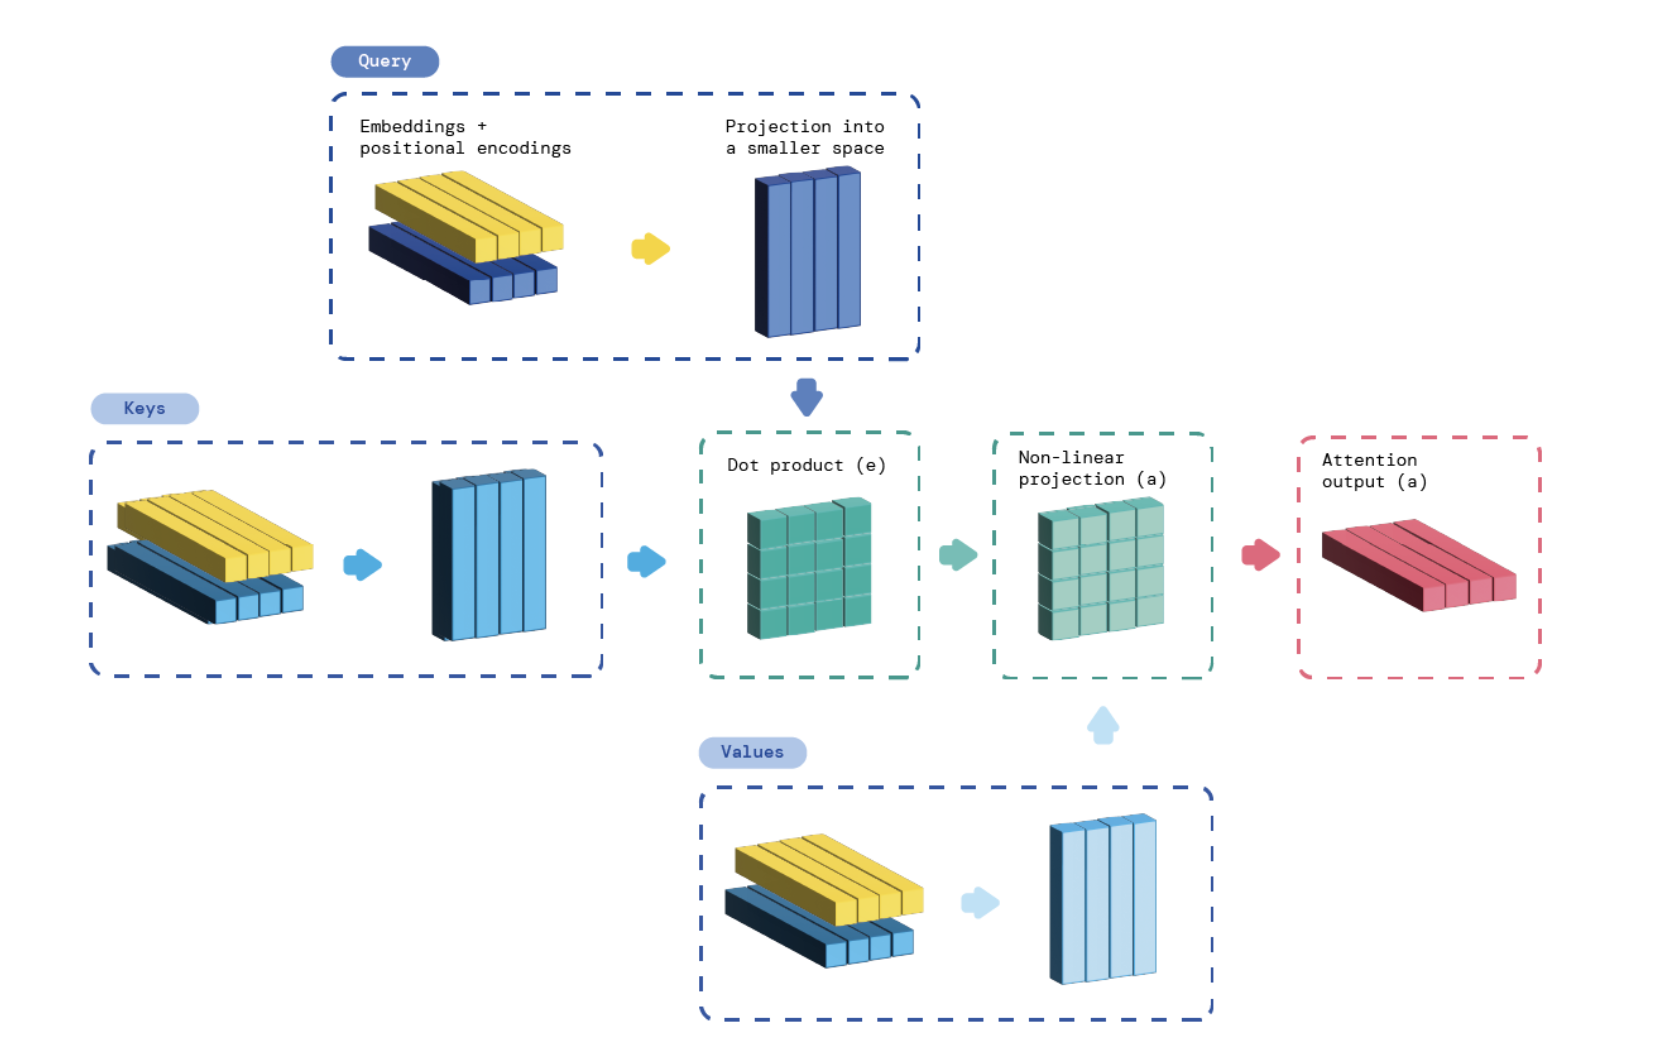


What happens here is similar to what we did in the dot product attention in the previous section, just applying the mechanism to the sequence itself. For each element in the sequence, we calculate the attention weight matrix between $q_i$ and $K$. We then multiply $V$ by each weight and finally sum all weighted vectors $v_{weighted}$ together to form a new representation for $q_i$. By doing this, we are essentially drowning out irrelevant vectors and bringing up important vectors in the sequence when our focus is on $q_1$.

$QK^\top$ is scaled by the square root of the dimension of the vectors, $\sqrt{d_k}$, to ensure more stable gradients during training.


In [ ]:
#@title ⚙️ Compute the attention weights
def scaled_dot_product_attention(query, key, value):
    """Formula to return scaled dot product attention given QKV matrices."""
    d_k = key.shape[-1]

    # get the raw scores (logits) from dot producting the queries and keys
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))

    # scale the raw scores and apply the softmax function to get the attention scores/weights
    scaled_logits = logits / jnp.sqrt(d_k)
    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)

    # multiply the weights by the value matrix to get the output
    output = jnp.matmul(attention_weights, value)

    return output, attention_weights

<ipython-input-4-5925ce255053>:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(jnp.array(model.word_vec(word)))


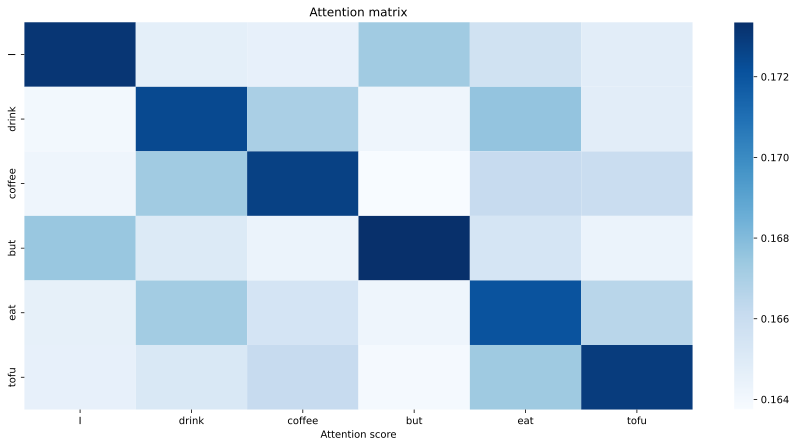

In [ ]:
#@title ⚙️ Visualize the attention
# define a sentence
sentence = "I drink coffee, but eat tofu"

# embed and create QKV matrices
word_embeddings, words = embed_sentence(sentence)
Q = K = V = word_embeddings

# calculate weights and plot
outputs, attention_weights = scaled_dot_product_attention(Q, K, V)

# plot the words and the attention weights between them
words = remove_punctuation(sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)

Keep in mind that we have not trained our attention matrix yet. However, we can see that by utilising the word2vec vectors as our sequence, we can see how scaled dot product attention already is capable of attending to "eat" when "steak" is our query and that the query "drink" attends more to "coke" and "eat".

More resources: [Attention with Q,K,V](https://www.youtube.com/watch?v=k-5QMalS8bQ&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=7)

##### **Masked attention**

There are cases where applying self-attention over the entire sequence is not practical. These can include:

- Uneven length sequences batched together.
  - When sending a batch of sequences through a network, the self-attention expects each sequence to be the same length. One handles this by padding the sequence. When calculating attention, ideally, these padding tokens should not be taken into consideration.
- Training a decoder model.
  - When training decoder models, such as GPT-3, the decoder has access to the entire target sequence when training (as training is done in parallel). In order to prevent the method from cheating by looking at future tokens, we have to mask the future sequence data so that earlier data can not attend to it.

By applying a mask to the final score calculated between queries and keys, we can mitigate the influence of the unwanted sequence vectors. **The vectors are masked by making the score between the query and their respective keys a VERY large negative value.** This results in the softmax function pushing the attention weight very close to zero, and the resulting value will be summed out and not influence the final representation.


Putting everything together, masked scaled dot product attention visually looks like this:

<img src="https://windmissing.github.io/NLP-important-papers/AIAYN/assets/5.png" alt="drawing" width="200"/>.


Text(0.5, 1.0, 'Example of mask that can be applied')

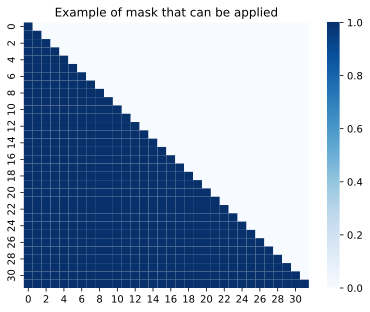

In [ ]:
#@title ⚙️ Example of building a mask for tokens of size 32
#@markdown The mask makes sure that positions only attend to previous positions in the input (causal mask)
# we will use this later to insert -inf values into the raw scores
mask = jnp.tril(jnp.ones((32, 32)))

# plot
sns.heatmap(mask, cmap="Blues")
plt.title("Example of mask that can be applied")

In [ ]:
#@title Causal attention
#@markdown Lets now adapt our scaled dot product attention function to implement masked attention.
def scaled_dot_product_attention(query, key, value, mask=None):
    """Scaled dot product attention with a causal mask

    Causal mask means that  the model is only allowed to attend
    to previous positions.
    """
    d_k = key.shape[-1]
    T_k = key.shape[-2]
    T_q = query.shape[-2]

    # get scaled logits using dot product as before
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
    scaled_logits = logits / jnp.sqrt(d_k)

    # add optional mask where values along the mask are set to -inf
    if mask is not None:
        scaled_logits = jnp.where(mask[:T_q, :T_k], scaled_logits, -jnp.inf)

    # calcualte the attention weights via softmax
    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)

    # sum with the values to get the output
    output = jnp.matmul(attention_weights, value)

    return output, attention_weights

##### **Multi-head attention**

The attention mechanism we've covered so far successfully allows the model to focus on different positions in the input. In practice, the transformer architecture uses a subtle variation of this mechanism, called multi-head attention (MHA).

The distinction is minimal; rather than only computing the attention once, the MHA mechanism runs through the scaled dot-product attention multiple times in parallel. According to the paper, *Attention is All You Need*, "multi-head attention allows the model to **jointly attend** to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this."

Multi-head attention can be viewed as a similar strategy to stacking convolution kernels in a CNN layer. This allows the kernels to focus on and learn different features and rules, which is why multiple heads of attention also work.

The figure below shows how basic MHA works. The scaled dot product attention discussed earlier is just repeated $N$ times ($N=2$ in this figure), with $3N$ learnable matrices for each head. The outputs from the different heads are then concatenated, whereafter it is fed through a linear projection, which produces the final representation.

In practice, MHA significantly out-performs single-head attention.

<img src="https://drive.google.com/uc?export=view&id=1q0Oq6IVEkkMfVSpY4LkHBP866mcoIFsh" alt="drawing" width="1000"/>


Let's take a look at how to implement multi-head attention. In simple terms, multi-head attention is like running the attention process multiple times in parallel, using different copies of the Q, K, and V matrices for each "head." This helps the model focus on different parts of the input at the same time. If you're interested in learning more, check out [this blog by Sebastian Raschka](https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention) for a detailed explanation.

In [ ]:
class MultiHeadAttention(nn.Module):
    num_heads: int  # Number of attention heads
    d_m: int  # Dimension of the model's embeddings

    def setup(self):
        # Initialize the sequence-to-QKV transformation module
        self.sequence_to_qkv = SequenceToQKV(self.d_m)

        # Define the initializer for the output linear layer weights
        initializer = nn.initializers.variance_scaling(
            scale=0.5, mode="fan_in", distribution="truncated_normal"
        )

        # Initialize the output projection layer Wo (used after attention)
        self.Wo = nn.Dense(self.d_m, kernel_init=initializer)

    def __call__(self, X=None, Q=None, K=None, V=None, mask=None, return_weights=False):
        # If Q, K, or V are not provided, use the input X to generate them
        if None in [Q, K, V]:
            assert not X is None, "X has to be provided if either Q, K, or V are not provided"

            # Generate Q, K, and V matrices from the input X
            Q, K, V = self.sequence_to_qkv(X)

        # Extract the batch size (B), sequence length (T), and embedding size (d_m)
        B, T, d_m = K.shape

        # Calculate the size of each attention head's embedding (d_m / num_heads)
        head_size = d_m // self.num_heads

        # Reshape Q, K, V to have separate dimensions for the heads
        # B, T, d_m -> B, T, num_heads, head_size -> B, num_heads, T, head_size
        q_heads = Q.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)
        k_heads = K.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)
        v_heads = V.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)

        # Apply scaled dot-product attention to each head
        attention, attention_weights = scaled_dot_product_attention(
            q_heads, k_heads, v_heads, mask
        )

        # Reshape the attention output back to its original dimensions
        # (B, num_heads, T, head_size) -> (B, T, num_heads, head_size) -> (B, T, d_m)
        attention = attention.swapaxes(1, 2).reshape(B, T, d_m)

        # Apply the output linear transformation Wo to the attention output
        X_new = self.Wo(attention)

        # If return_weights is True, return both the transformed output and attention weights
        if return_weights:
            return X_new, attention_weights
        else:
            # Otherwise, return just the transformed output
            return X_new

## <font color='orange'> 🪴 Intermediate: </font> Transformer Architecture

The Transformer Architecture was famously introduced in the paper entitled [Attention is all you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) by Vaswani et al.

As the title of the paper suggests, such an architecture consists of basically only attention mechanisms along with feed-forward layers and linear layers, as shown in the diagram below.

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="350" />

Transformers and its variations are in the core of Large Language Models and it's not an exaggeration to say that almost all language models out there are Transformer based architectures.

As you can see in the diagram the original Transformer architecture consists of two parts, one that receives inputs usually called encoder and another that receives outputs (i.e. targets) called decoder. This is because the transformer was designed for machine translation.

The encoder will receive an input sentence in one language and process it through multiple stacked `encoder blocks`. This creates a final representation, which contains helpful information necessary for the decoding task. This output is then fed into stacked `decoder blocks` that produce new outputs in an autoregressive manner.

The encoder consists of $N$ identical blocks, which process a sequence of token vectors sequentially. These blocks consist of 3 parts:

1. A multi-head attention block. These are the transformer architecture's backbone. They process the data to generate representations for each token, ensuring that the necessary information for the task at hand is represented in the vectors. These are exactly the MHA we covered in the attention section previously.
2. An MLP (Multi-Layer Perceptron i.e. a neural network with multiple layers) is applied to each input token separately and identically.
3. Residual connection that adds the input tokens to the attended representations and a residual connection between the input to the MLP and its outputs. For both these connections, the result is normalized using layernorm. In certain implementations, these normalization steps are applied to the inputs rather than the outputs. Just like a Resnet, transformers are designed to be very deep models thus, these add and norm blocks are essential for a smooth gradient flow.  

Similarly, the decoder block consists of $N$ identical blocks, however there is some variation within these block. Concretely, the different parts are:

1. A masked multi-head attention block. This is an MHA block that performs _self-attention_ on the output sequence however this computation is restricted to the inputs that have already been seen. In other words, future tokens are blocked when making predictions.
2. A multi-head attention block. This block receives the output of the final encoder block, the transformed tokens, and uses that as the key-value pairs, while using the output of the first MHA block as the query. In doing this, the model attends over the input required to perform the sequence task. This MHA block thus performs _cross-attention_ by looking at the encoder inputs.
3. An MLP same as the encoder
4. Residual connection same as the encoder.

Given this original architecture, there have been several variation with others focusing on the encoder only and others the **decoder only**. Large language models(LLMs) such as GPT-2, GPT-3 and Turing-NLG were born out of decoder only architectures. These architecture look like:

<img src="https://drive.google.com/uc?export=view&id=1MubUcshJTHCqOPTRHixLhrYYLXX9vP_h" alt="drawing" width="260"/>

with the cross attention block missing as no encoder output is available. So to build a language model, we will focus on the decoder only architecture as seen above.


### <font color='green'> 🌱 Beginner:</font> Tokenization + Positional encoding


Transformers cannot handle raw strings of text. So to process text, the text is first split up into tokens, as we seen before.  

The tokens are then indexed and each token is assigned an embedding of size $d_{model}$. These embeddings can be learned during training or can come from a pretrained vocabulary of embeddings. This new sequence of token embeddings is then fed into the transformer architecture. This idea is visualised below.



<img src="https://drive.google.com/uc?export=view&id=16euh4LADP_mcXywFwKKY3QQQkVplepiI" alt="drawing" width="450"/>


These token IDs are typically predicted when a model generates text, fills in missing words, etc.

This process of splitting up text into tokens and assigning an ID to each token is called [tokenisation](https://huggingface.co/docs/transformers/tokenizer_summary). There are various ways to tokenise text, with some methods being trained directly from the data. When using pre-trained transformers, it is crucial to use the same tokeniser that was used to train the model. The previous link has in-depth descriptions of many widely known techniques.

Below we show how the [BERT](https://arxiv.org/abs/1810.04805) model's tokeniser tokenises a sentence. We use [Hugging Face](https://huggingface.co/) for this part.


In [ ]:
#@title Tokenizing text using  [BERT](https://arxiv.org/abs/1810.04805)
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_input = bert_tokenizer("The practical is so much fun")
print(f"Token IDs: {encoded_input['input_ids']}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Token IDs: [101, 1109, 6691, 1110, 1177, 1277, 4106, 102]


Here we can see that the tokeniser returns the IDs for each token, as shown in the figure. But counting the number of IDs, we see that it is larger than the number of words in the sentence. Let's print the tokens associated with each ID.


In [ ]:
print(f"Tokens: {bert_tokenizer.decode(encoded_input['input_ids'])}")

Tokens: [CLS] The practical is so much fun [SEP]


We can see the tokeniser attaches new tokens, `[CLS]` and `[SEP]`, to the start and end of the sequence. This is a BERT-specific requirement for training and inference.

Adding special tokens is a very common thing to do. Using special tokens, we can tell a model when a sentence starts or ends or when a new part of the input starts. This can be helpful when performing different tasks.

For instance, to pretrain specific transformers, they perform what is known as masked prediction. For this, random tokens in a sequence are replaced by the `[MASK]` token, and the model is trained to predict the correct token ID for the token replaced with that token.

**Drawback of using raw token**

One drawback of using raw tokens is that they lack any indication of the word's position in the sequence. This is evident when considering sentences like "I am happy" and "Am I happy" - these two phrases have distinct meanings, and the model needs to grasp the word order to understand the intended message accurately.

To address this, when converting the inputs into vectors, position vectors are introduced and added to these vectors to indicate the **position** of each word.


#### Positional encodings

In most domains where a transformer can be utilised, there is an underlying order to the tokens produced, be it the order of words in a sentence, the location from which patches are taken in an image or even the steps taken in an RL environment. This order is very important in all cases; just imagine you interpret the sentence "I have to read this book." as "I have this book to read.". Both sentences contain the exact same words, yet they have completely different meanings based on the order.

As both the encoder and the decoder blocks process all tokens in parallel, the order of tokens is lost in these calculations. To cope with this, the sequence order has to be injected into the tokens directly. This can be done by adding *positional encodings* to the tokens at the start of the encoder and decoder blocks (though some of the latest techniques add positional information in the attention blocks). An example of how positional encodings alter the tokens is shown below.


\\

<img src="https://drive.google.com/uc?export=view&id=1eSgnVN2hnEsrjdHygDGwk1kxEi8-dcFo" alt="drawing" width="650"/>

Ideally, these encodings should have these characteristics ([source](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)):
* Each time-step should have a unique value
* The distance between time steps should stay constant.
* The encoding should be able to generalise to longer sequences than seen during training.
* The encoding must be deterministic.

##### **Sine and cosine functions**


In Attention is All you Need, the authors used a method that can satisfy all these requirements. This involves summing a combination of sine and cosine waves at different frequencies, with the formula for a position encoding at position $D$ shown below, where $i$ is the embedding index and $d_m$ is the token embedding size.

\\

$P_{D}= \begin{cases}\sin \left(\frac{D}{10000^{i/d_{m}}}\right), & \text { if } i \bmod 2=0 \\ \cos \left(\frac{D}{10000^{((i-1)/d_{m}}}\right), & \text { otherwise } \end{cases}$

\

Assuming our model as $d_m=8$, the position embedding will look like this:

\
$P_{D}=\left[\begin{array}{c}\sin \left(\frac{D}{10000^{0/8}}\right)\\ \cos \left(\frac{D}{10000^{0/8}}\right)\\ \sin \left(\frac{D}{10000^{2/8}}\right)\\ \cos \left(\frac{D}{10000^{2/8}}\right)\\ \sin \left(\frac{D}{10000^{4/8}}\right)\\ \cos \left(\frac{D}{10000^{4/8}}\right)\\ \sin \left(\frac{D}{10000^{8/8}}\right)\\ \cos \left(\frac{D}{10000^{8/8}}\right)\end{array}\right]$

\\

Let's first create a function that can return these encodings to understand why this will work.

In [ ]:
#@title Get the positional encodings
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

  assert token_embedding % 2 == 0, "token_embedding should be divisible by two"

  positional_encoding = jnp.zeros((token_sequence_length, token_embedding))
  positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

  i = jnp.arange(0, token_embedding, 2)
  frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
  frequencies = positions * frequency_steps

  positional_encoding = positional_encoding.at[:, 0::2].set(jnp.sin(frequencies))
  positional_encoding = positional_encoding.at[:, 1::2].set(jnp.cos(frequencies))

  return positional_encoding

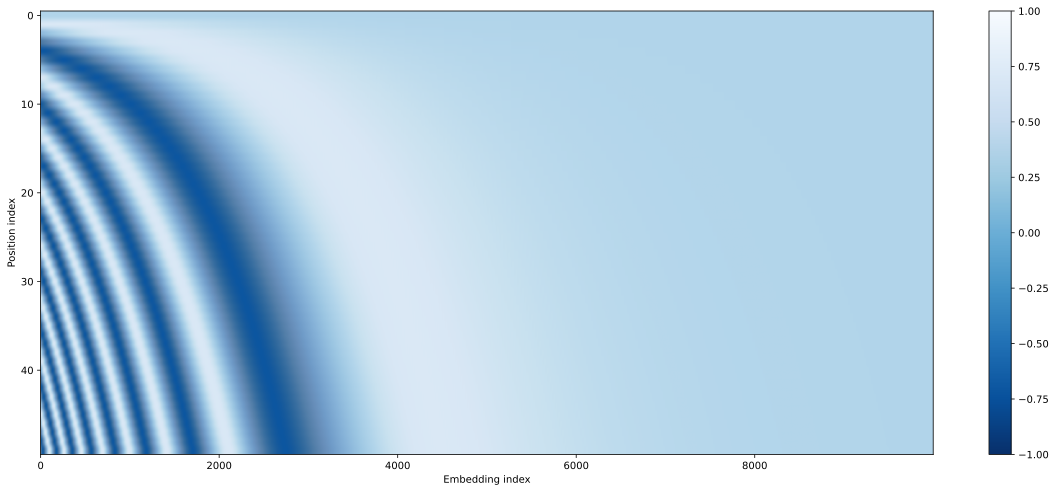

In [ ]:
token_sequence_length = 50  # Number of tokens the model will need to process
token_embedding = 10000  # token embedding (and positional encoding) dimensions, ensure it is divisible by two
positional_encoding = return_frequency_pe_matrix(token_sequence_length, token_embedding)
plot_position_encodings(positional_encoding, token_sequence_length, token_embedding)

Looking at the graph above, we can see that for each position index, a unique pattern emerges, where each position index consistently has the same encoding.


<font color='784fb7'><b> 🛠️ Group task:</b></font>
<ul>
  <li><font color='784fb7'>Take a moment with your friend to explore why this specific pattern appears when `token_sequence_length` is set to 1000, and `token_embedding` is 768.</font>
  <li><font color='784fb7'>Experiment with smaller values for `token_sequence_length` and `token_embedding` to build a deeper understanding and enhance your discussion.</font>
  <li><font color='784fb7'>Now, try setting `token_sequence_length` to 50 and `token_embedding` to a much larger value, like 10000. What do you observe? Do we always need a large token embedding?</font>
</ul>



### <font color='orange'>🪴 Intermediate:</font> Transformer block   

Just like an MLP (a simple neural network that processes input data through multiple layers) or a CNN (a type of neural network that excels at recognizing patterns in images by using convolution layers), transformers are made up of a stack of transformer blocks. In this section, we'll build each of the components needed to create one of these transformer blocks.


#### <font color='green'> 🌱 Beginner:</font> Feed Forward Network (FFN) / Multilayer perceptron (MLP)


<img src="https://drive.google.com/uc?export=view&id=1H1pVFxJiSpM_Ozj1eKWNdcFQ5Hn5XsZz" alt="drawing" width="260"/>

In the original model, these blocks consist of a simple 2-layer MLP (Multi-Layer Perceptron) that uses ReLU activation. However, GeLU (Gaussian Error Linear Unit) has become very popular, and we will be using it throughout this practical. The formula below represents the feedforward neural network (FFN) with GeLU activation. In this network, the input `x` is first passed through two linear layers with weights `W1` and `W2`, followed by bias terms `b1` and `b2`. The ReLU activation function, often represented by the `max` function, is replaced by the GeLU activation function in this case.

$$
\operatorname{FFN}(x)=\max \left(0, x W_{1}+b_{1}\right) W_{2}+b_{2}
$$

One can interpret this block as processing what the MHA block has produced and then projecting these new token representations to a space that the next block can use more optimally. Usually, the first layer is very wide, in the range of 2-8 times the size of the token representations. They do this as it is easier to parallelize computations for a single wider layer during training than to parallelize a feedforward block with multiple layers. Thus they can add in more complexity but keep training and inference optimized.

In [ ]:
#@title ⚒️ Code task:  Code up a Flax Module that implements the feed forward block.

class FeedForwardBlock(nn.Module):
  """
  A 2-layer MLP which widens then narrows the input.

  Args:
    widening_factor [optional, default=4]: The size of the hidden layer will be d_model * widening_factor.
  """

  widening_factor: int = 4
  init_scale: float = 0.25

  @nn.compact
  def __call__(self, x):
    '''
    Args:
      x: [B, T, d_m]

    Return:
      x: [B, T, d_m]
    '''
    d_m = x.shape[-1]
    layer1_size = self.widening_factor * d_m

    initializer = nn.initializers.variance_scaling(
        scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
    )

    # Hint: Layer 1 is a dense layer (fully connected layer) that increases the size of the input by the widening factor.
    # Use nn.Dense to create this layer with layer1_size as the output size.
    layer1 = # FINISH ME

    # Hint: Layer 2 is another dense layer that reduces the size back to the original dimension d_m.
    # Use nn.Dense with d_m as the output size to create this layer.
    layer2 = # FINISH ME

    x = jax.nn.gelu(layer1(x))  # Apply the GeLU activation function to the output of layer 1
    x = layer2(x)  # Pass the result through layer 2
    return x

In [ ]:
# @title ✅ Solution to the task (Try not to peek until you've given it a good try!')

class FeedForwardBlock(nn.Module):
    """A 2-layer MLP (Multi-Layer Perceptron) that first expands the input size and then reduces it back."""

    # widening_factor controls how much the input dimension is expanded in the first layer.
    widening_factor: int = 4

    # init_scale controls the scaling factor for weight initialization.
    init_scale: float = 0.25

    @nn.compact
    def __call__(self, x):
        # Get the size of the last dimension of the input (embedding size).
        d_m = x.shape[-1]

        # Calculate the size of the first layer by multiplying the embedding size by the widening factor.
        layer1_size = self.widening_factor * d_m

        # Initialize the weights for both layers using a variance scaling initializer.
        initializer = nn.initializers.variance_scaling(
            scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
        )

        # Define the first dense layer, which expands the input size.
        layer1 = nn.Dense(layer1_size, kernel_init=initializer)

        # Define the second dense layer, which reduces the size back to the original dimension.
        layer2 = nn.Dense(d_m, kernel_init=initializer)

        # Apply the first dense layer followed by a GELU activation function.
        x = jax.nn.gelu(layer1(x))

        # Apply the second dense layer to project the data back to its original dimension.
        x = layer2(x)

        # Return the final output.
        return x

#### <font color='green'>🌱 Beginner: </font>Add and Norm block

In order to get transformers to go deeper, the residual connections are very important to allow an easier flow of gradients through the network.

For normalisation, `layer norm` is used. This normalises each token vector independently in the batch. It is found that normalising the vectors improves the convergence and stability of transformers.

There are two learnable parameters in layernorm, `scale` and `bias`, which rescales the normalised value. Thus, for each input token in a batch, we calculate the mean, $\mu_{i}$ and variance $\sigma_i^2$. We then normalise the token with:

$\hat{x}_i = \frac{x_i-\mu_{i}}{\sigma_i^2 + ϵ}$.

Then $\hat{x}$ is rescaled using the learned `scale`, $γ$, and `bias` $β$, with:

$y_i = γ\hat{x}_i + β = LN_{γ,β}(x_i)$.

So our add norm block can be represented as $LN(x+f(x))$, where $f(x)$ is either a MLP or MHA block.



In [ ]:
#@title ⚒️ Code task:  Code up a Flax Module that implements the add norm block.
#@markdown It should take as input the processed and unprocessed tokens. Hint: `nn.LayerNorm `

class AddNorm(nn.Module):
  """A block that impliments the add and norm block"""

  @nn.compact
  def __call__(self, x, processed_x):
    '''
    Args:
      x: Sequence of tokens before feeding into MHA or FF blocks, with shape [B, T, d_m]
      x: Sequence of after being processed by MHA or FF blocks, with shape [B, T, d_m]

    Return:
      add_norm_x: Transformed tokens with shape [B, T, d_m]
    '''
    # Hint: Step 1 involves adding the original input `x` to the processed input `processed_x`.
    added = # FINISH ME

    # Hint: Step 2 requires applying layer normalization to the result of the addition.
    # Use `nn.LayerNorm`, and set `reduction_axes=-1` to apply normalization across the last dimension.
    normalised = #FINISH ME
    return normalised(added)

In [ ]:
# @title ✅ Solution to the task (Try not to peek until you've given it a good try!')

class AddNorm(nn.Module):
    """A block that implements the 'Add and Norm' operation used in transformers."""

    @nn.compact
    def __call__(self, x, processed_x):
        # Step 1: Add the original input (x) to the processed input (processed_x).
        added = x + processed_x

        # Step 2: Apply layer normalization to the result of the addition.
        # - LayerNorm helps to stabilize and improve the training process by normalizing the output.
        # - reduction_axes=-1 indicates that normalization is applied across the last dimension (typically the embedding dimension).
        # - use_scale=True and use_bias=True allow the layer to learn scaling and bias parameters for further fine-tuning.
        normalised = nn.LayerNorm(reduction_axes=-1, use_scale=True, use_bias=True)

        # Return the normalized result.
        return normalised(added)

#### <font color='orange'>🪴 Intermediate</font> Building the Transformer Decoder / LLM

<img src="https://drive.google.com/uc?export=view&id=1MubUcshJTHCqOPTRHixLhrYYLXX9vP_h" alt="drawing" width="260"/>

Most of the groundwork has happened. We have built the positional encoding block, the MHA block, the feed-forward block and the add&norm block.

The only part needed is passing inputs to each decoder block and applying the masked MHA block found in the decoder blocks.



In [ ]:
#@title ⚒️ Code task: code up a FLAX Module that implements the `(FFN(norm(MHA(norm(X)))))` for the decoder block

class DecoderBlock(nn.Module):
  """
  Transformer decoder block.

  Args:
    num_heads: The number of heads to be used in the MHA block.
    d_m: Token embedding size
    widening factor: The size of the hidden layer will be d_m * widening_factor.
  """

  num_heads: int
  d_m: int
  widening_factor: int = 4

  def setup(self):
    self.mha = MultiHeadAttention(self.num_heads, self.d_m)
    self.add_norm1 = AddNorm()
    self.add_norm2 = AddNorm()
    self.MLP = FeedForwardBlock(widening_factor=self.widening_factor)

  def __call__(self, X, mask=None, return_att_weight=True):
    """
    Args:
      X: Batch of tokens being fed into the decoder, with shape [B, T_decoder, d_m]
      encoder_output: Batch of tokens with was processed by the encoder, with shape [B, T_encoder, d_m]
      mask [optional, default=None]: Mask to be applied, with shape [T_decoder, T_decoder].
      return_att_weight [optional, default=True]: Whether to return the attention weights.
    """

    attention, attention_weights_1 = # FINISH ME

    X = # FINISH ME

    projection = # FINISH ME
    X = # FINISH ME

    return (X, attention_weights_1) if return_att_weight else X

In [ ]:
# @title ✅ Solution to the task (Try not to peek until you've given it a good try!')

class DecoderBlock(nn.Module):
    """
    Transformer decoder block.

    Args:
        num_heads: The number of attention heads in the Multi-Head Attention (MHA) block.
        d_m: The size of the token embeddings.
        widening_factor: The factor by which the hidden layer size is expanded in the MLP.
    """

    num_heads: int
    d_m: int
    widening_factor: int = 4

    def setup(self):
        # Initialize the Multi-Head Attention (MHA) block
        self.mha = MultiHeadAttention(self.num_heads, self.d_m)

        # Initialize the AddNorm blocks for residual connections and normalization
        self.add_norm1 = AddNorm()  # First AddNorm block after MHA
        self.add_norm2 = AddNorm()  # Second AddNorm block after the MLP

        # Initialize the FeedForwardBlock (MLP) which processes the data after attention
        self.MLP = FeedForwardBlock(widening_factor=self.widening_factor)

    def __call__(self, X, mask=None, return_att_weight=True):
        """
        Forward pass through the DecoderBlock.

        Args:
            X: Batch of input tokens fed into the decoder, shape [B, T_decoder, d_m]
            mask [optional, default=None]: Mask to control which positions the attention is allowed to consider, shape [T_decoder, T_decoder].
            return_att_weight [optional, default=True]: If True, returns the attention weights along with the output.

        Returns:
            If return_att_weight is True, returns a tuple (X, attention_weights_1).
            Otherwise, returns the processed token representations X.
        """

        # Apply Multi-Head Attention to the input tokens (X) with optional masking
        attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)

        # Apply the first AddNorm block (adds the original input X and normalizes)
        X = self.add_norm1(X, attention)

        # Pass the result through the FeedForwardBlock (MLP) to further process the data
        projection = self.MLP(X)

        # Apply the second AddNorm block (adds the input from the previous step and normalizes)
        X = self.add_norm2(X, projection)

        # Return the final output X, and optionally the attention weights
        return (X, attention_weights_1) if return_att_weight else X


In [ ]:
#@title ⚙️ LLM
#@markdown Next, we just put everything together, adding in the positional encodings as well as stacking multiple transformer blocks and adding our prediction layer.
class LLM(nn.Module):
    """
    Transformer model consisting of several layers of decoder blocks.

    Args:
        num_heads: Number of attention heads in each Multi-Head Attention (MHA) block.
        num_layers: Number of decoder blocks in the model.
        d_m: Dimensionality of the token embeddings.
        vocab_size: Size of the vocabulary (number of unique tokens).
        widening_factor: Factor by which the hidden layer size is expanded in the MLP.
    """
    num_heads: int
    num_layers: int
    d_m: int
    vocab_size: int
    widening_factor: int = 4

    def setup(self):
        # Initialize a list of decoder blocks, one for each layer in the model
        self.blocks = [
            DecoderBlock(self.num_heads, self.d_m, self.widening_factor)
            for _ in range(self.num_layers)
        ]

        # Initialize an embedding layer to convert token IDs into token embeddings
        self.embedding = nn.Embed(
            num_embeddings=self.vocab_size, features=self.d_m)

        # Initialize a dense layer for predicting the next token in the sequence
        self.pred_layer = nn.Dense(self.vocab_size)

    def __call__(self, X, mask=None, return_att_weights=False):
        """
        Forward pass through the LLM model.

        Args:
            X: Batch of input token IDs, shape [B, T_decoder] where B is batch
              size and T_decoder is sequence length.
            mask [optional, default=None]: Mask to control which positions
              the attention can focus on, shape [T_decoder, T_decoder].
            return_att_weights [optional, default=False]: Whether to return
              the attention weights.

        Returns:
            logits: The predicted probabilities for each token in the vocabulary.
            If return_att_weights is True, also returns the attention weights.
        """

        # Convert token IDs to embeddings (shape [B, T_decoder, d_m])
        X = self.embedding(X)

        # Get the sequence length of the input
        sequence_len = X.shape[-2]

        # Generate positional encodings and add them to the token embeddings
        positions = return_frequency_pe_matrix(sequence_len, self.d_m)
        X = X + positions

        # Initialize a list to store attention weights if needed
        if return_att_weights:
            att_weights = []

        # Pass the embeddings through each decoder block in sequence
        for block in self.blocks:
            out = block(X, mask, return_att_weights)
            if return_att_weights:
                # If returning attention weights, unpack the output
                X = out[0]
                att_weights.append(out[1])
            else:
                # Otherwise, just update the input for the next block
                X = out

        # Apply a dense layer followed by a log softmax to get logits
        # (predicted token probabilities)
        logits = nn.log_softmax(self.pred_layer(X))

        # Return the logits, and optionally, the attention weights
        return logits if not return_att_weights else (logits, jnp.array(att_weights).swapaxes(0, 1))

In [ ]:
#@title ⚙️ Test your LLM
#@markdown If everything is correct, then if we run the code, everything should run without any issues.
B, T, d_m, N, vocab_size = 18, 32, 16, 8, 25670

llm = LLM(num_heads=1, num_layers=1, d_m=d_m, vocab_size=vocab_size, widening_factor=4)
mask = jnp.tril(np.ones((T, T)))

# initialise module and get dummy output
key = jax.random.PRNGKey(42)
X = jax.random.randint(key, [B, T], 0, vocab_size)
params = llm.init(key, X, mask=mask)

# extract output from decoder
logits, decoder_att_weights = llm.apply(
    params,
    X,
    mask=mask,
    return_att_weights=True,
)

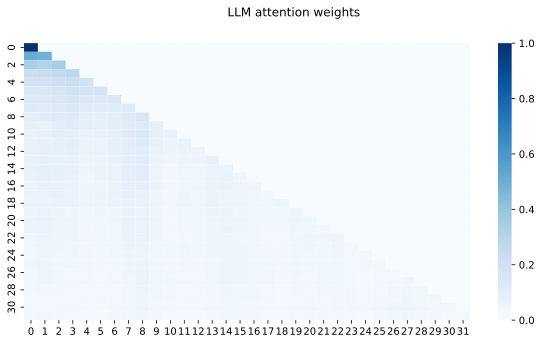

In [ ]:
#@title ⚙️ Visualize attention weights
#@markdown As a final sanity check, we can confirm that our attention weights are working correctly. As shown in the figure below, the decoder's attention weights only focus on previous tokens, as expected.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle("LLM attention weights")
sns.heatmap(decoder_att_weights[0, 0, 0, ...], ax=ax, cmap="Blues")
fig.show()

### <font color='orange'> 🪴 Intermediate </font> Training your own LLM from scratch

####Training objective


A sentence is nothing but a string of words. A LLM aims to predict the next word by considering the current context, namely the words that have come before.

Here's the basic idea:

To calculate the probability of a full sentence "word1, word2, ..., last word" appearing in a given context $c$, the procedure is to break down the sentence into individual words and consider the probability of each word given the words that precede it. These individual probabilities are then multiplied together:

$$\text{Probability of sentence} = \text{Probability of word1} \times \text{Probability of word2} \times \ldots \times \text{Probability of last word}$$

This method is akin to building up a narrative one piece at a time based on the preceding storyline.

Mathematically, this is expressed as the likelihood (probability) of a sequence of words $y_1, y_2, ..., y_n$ in a given context $c$, which is achieved by multiplying the probabilities of each word $y_t$ calculated given the predecessors ($y_{<t}$) and the context $c$:

$$
P\left(y_{1}, y_{2}, \ldots, y_{n}, \mid c\right)=\prod_{t=1}^{n} P\left(y_{t} \mid y_{<t}, c\right)
$$

Here $y_{<t}$ stands for the sequence $y_1, y_2, ..., y_{t-1}$, while $c$ represents the context.

This is analogous to solving a jigsaw puzzle where the next piece is predictively placed based on what's already in place.

Remember just when training a transformer, we do not work in words, but in tokens. During the training process, the model's parameters are fine-tuned by computing the cross-entropy loss across the predicted token, and the correct token, and then performing backpropagation. The loss for time step "t" is computed as:

$$ \text{Loss}_t = - \sum_{w \in V} y_t\log (\hat{y}_t) $$

Here $y_t$ is the actual token at time step $t$, and $\hat{y}_t$ is the token predicted by the model at the same time step. The loss for the entire sentence is then computed as:

$$ \text{Sentence Loss} = \frac{1}{n} \sum^{n}_{t=1} \text{Loss}_t $$

where $n$ is the length of the sequence.

This iterative process ultimately hones the model's predictive capabilities over time.



In [ ]:
#@title 🛠️ Code task: Implement the cross-entropy loss function below.
def sequence_loss_fn(logits, targets):
  '''
  Compute the cross-entropy loss between predicted token ID and true ID.

  Args:
    logits: An array of shape [batch_size, sequence_length, vocab_size]
    targets: The targets we are trying to predict

  Returns:
    loss: A scalar value representing the mean batch loss
  '''

  target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)
  assert logits.shape == target_labels.shape

  mask = jnp.greater(targets, 0)

  # Hint: Compute the cross-entropy loss by first applying `jax.nn.log_softmax(logits)`
  # to get the log probabilities for each class. Then, multiply these log probabilities
  # by the `target_labels` to focus on the correct class's probability. Sum this result
  # along the last axis to get the loss for each token. Finally, apply the mask to the loss,
  # sum the masked losses, and normalize by the number of non-padding tokens.
  loss = # FINISH ME

  return loss

In [ ]:
# @title Run me to test your code
VOCAB_SIZE = 25670
targets = jnp.array([[0, 2, 0]])
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [1, 3, VOCAB_SIZE])
loss = sequence_loss_fn(X, targets)
real_loss = jnp.array(10.966118)
assert jnp.allclose(real_loss, loss), "Not returning the correct value"
print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


In [ ]:
# @title ✅ Solution to the task (Try not to peek until you've given it a good try!')
def sequence_loss_fn(logits, targets):
    """Compute the sequence loss between predicted logits and target labels."""

    # Convert the target indices to one-hot encoded vectors.
    # Each target label is converted into a one-hot vector of size VOCAB_SIZE.
    target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)

    # Ensure that the shape of logits matches the shape of the one-hot encoded targets.
    # This is important because we need to compute the loss across matching dimensions.
    assert logits.shape == target_labels.shape

    # Create a mask that ignores padding tokens in the loss calculation.
    # The mask is True (1) where the target value is greater than 0 and False (0) otherwise.
    mask = jnp.greater(targets, 0)

    # Compute the cross-entropy loss for each token.
    # Cross-entropy is calculated as the negative log probability of the correct class.
    # jax.nn.log_softmax(logits) gives us the log probabilities for each class.
    # We multiply by the target_labels to select the log probability of the correct class.
    loss = -jnp.sum(target_labels * jax.nn.log_softmax(logits), axis=-1)

    # Apply the mask to the loss to ignore padding positions and sum up the losses.
    # We then normalize the total loss by the number of non-padding tokens.
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

####<font color='blue'> 🌳 Advanced:</font>  Training models

In the next section, we define all the processes required to train the model using the objective described above. A lot of this is now the work required to do training using FLAX.

Below we gather the dataset and we shall be training on, which is Karpathy's shakespeare dataset. Its not so important to understand this code, so either just run the cell to load the data, or view the code if you want to understand it.


In [ ]:
#@title  ⚙️ Create Shakespeare dataset and iterator (optional, but run the cell)

# Trick to avoid errors when downloading tinyshakespeare.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

class WordBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into words
        words = corpus.split()
        self.vocab_size = len(set(words))  # Number of unique words

        # Create a mapping from words to unique IDs
        self.word_to_id = {word: i for i, word in enumerate(set(words))}

        # Store the inverse mapping from IDs to words
        self.id_to_word = {i: word for word, i in self.word_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.word_to_id[word] for word in words]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = WordBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_words(self, ids):
        """Convert a sequence of word IDs to words."""
        return [self.id_to_word[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


--2025-03-02 17:18:09--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2025-03-02 17:18:09 (12.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
#@title ⚙️ Inspect the data that we'll be using for training
# sample and look at the data
batch_size = 2
seq_length = 32
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)

batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Input", "-" * 11)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(obs)))
    print("ASCII:", obs)
    print("-" * 10, "Target", "-" * 10)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(target)))
    print("ASCII:", target)

print(f"\n Total vocabulary size: {train_dataset.vocab_size}")

VOCAB_SIZE = train_dataset.vocab_size

---------- Input -----------
TEXT: than can ever Appear in your impediment. For the dearth, The gods, not the patricians, make it, and Your knees to them, not arms, must help. Alack, You are transported by calamity
ASCII: [12246 15262 18123 20004 11767  5763  5846 21961  1939 16801  9162 19901
 12724  1939  5667  3069 24526 16996  8509  2584  8846  2480 12724 23678
 25080 16994 18512 23522 15980  2946 18395 24820]
---------- Target ----------
TEXT: can ever Appear in your impediment. For the dearth, The gods, not the patricians, make it, and Your knees to them, not arms, must help. Alack, You are transported by calamity Thither
ASCII: [15262 18123 20004 11767  5763  5846 21961  1939 16801  9162 19901 12724
  1939  5667  3069 24526 16996  8509  2584  8846  2480 12724 23678 25080
 16994 18512 23522 15980  2946 18395 24820 24928]
---------- Input -----------
TEXT: First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citizen: You are all resolved rather to 

In [ ]:
#@title  ⚙️ Train LLM
#@markdown Next, let us train our LLM and see how it performs in producing Shakespearian text.
#@markdown First, we will define what happens for every training step.
import functools

@functools.partial(jax.jit, static_argnums=(3, 4))
def train_step(params, optimizer_state, batch, apply_fn, update_fn):
    """
    Perform a single training step.

    Args:
        params: The current parameters of the model.
        optimizer_state: The current state of the optimizer.
        batch: A dictionary containing the input data and target labels for the batch.
        apply_fn: The function used to apply the model to the inputs.
        update_fn: The function used to update the model parameters based on the gradients.

    Returns:
        Updated parameters, updated optimizer state, and the computed loss for the batch.
    """

    def loss_fn(params):
        # Get the sequence length (T) from the input data.
        text_shape = batch['input'].shape[1]

        # Apply the model to the input data, using a lower triangular mask to enforce causality.
        # jnp.tril(np.ones((text_shape, text_shape))) creates a lower triangular matrix of ones.
        logits = apply_fn(params,
                          batch['input'],
                          jnp.tril(np.ones((text_shape, text_shape))))

        # Calculate the loss between the predicted logits and the target labels.
        loss = sequence_loss_fn(logits, batch['target'])

        return loss

    # Compute the loss and its gradients with respect to the parameters.
    loss, gradients = jax.value_and_grad(loss_fn)(params)

    # Update the optimizer state and calculate the parameter updates based on the gradients.
    updates, optimizer_state = update_fn(gradients, optimizer_state)

    # Apply the updates to the parameters.
    params = optax.apply_updates(params, updates)

    # Return the updated parameters, optimizer state, and the loss for the batch.
    return params, optimizer_state, loss

In [ ]:
#@title ⚙️ Initialise our optimizer and model.
#@markdown Feel free to play with the hyperparameters during the practical.

# Define all hyperparameters
d_model = 128            # Dimension of token embeddings (d_m)
num_heads = 4            # Number of attention heads in Multi-Head Attention
num_layers = 1           # Number of decoder blocks in the model
widening_factor = 2      # Factor to widen the hidden layer size in the MLP
LR = 2e-3                # Learning rate for the optimizer
batch_size = 32          # Number of samples per training batch
seq_length = 64          # Length of each input sequence (number of tokens)

# Set up the training data
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size  # Get the size of the vocabulary from the dataset
batch = next(train_dataset)            # Get the first batch of input data

# Set the random number generator key for model initialization
rng = jax.random.PRNGKey(13)

# Initialize the LLM model with the specified hyperparameters
llm = LLM(num_heads=num_heads, num_layers=num_layers, d_m=d_model, vocab_size=vocab_size, widening_factor=widening_factor)

# Create a causal mask to ensure that the model only attends to previous tokens
mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))

# Initialize the model parameters using the first batch of input data and the mask
params = llm.init(rng, batch['input'], mask)

# Set up the optimizer using the Adam optimization algorithm with the specified learning rate
optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)  # Initialize the optimizer state with the model parameters

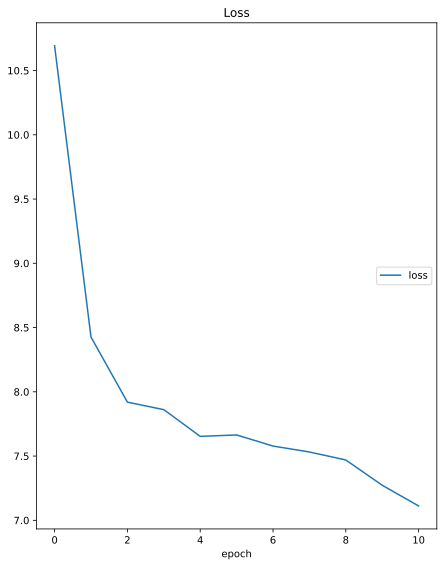

Loss
	loss             	 (min:    7.112, max:   10.692, cur:    7.112)


In [ ]:
#@title ⚙️ Train a model
#@markdown This will take a few minutes.. While it trains, have you greeted your neighbour yet?

plotlosses = PlotLosses()

MAX_STEPS = 3500
LOG_EVERY = 32
losses = []
VOCAB_SIZE = 25670

# Training loop
for step in range(MAX_STEPS):
    batch = next(train_dataset)
    params, optimizer_state, loss = train_step(
        params, optimizer_state, batch, llm.apply, optimizer.update)
    losses.append(loss)
    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []

#### <font color='green'> 🌱 Beginner: </font>Inspecting the trained LLM


**Reminder:** remember to run all code presented so far in this section before runnning the cells below!

Lets generate some text now and see how our model did. DO NOT STOP THE CELL ONCE IT IS RUNNING, THIS WILL CHRASH THE SESSION.

In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(2, ))
def generate_prediction(params, input, apply_fn):
  logits = apply_fn(params, input)
  argmax_out = jnp.argmax(logits, axis=-1)
  return argmax_out[0][-1].astype(int)

def generate_random_shakespeare(llm, params, id_2_word, word_2_id):
    """Get the model output"""

    prompt = "Love"
    print(prompt, end="")
    tokens = prompt.split()

    # predict and append
    for i in range(15):
      input = jnp.array([[word_2_id[t] for t in tokens]]).astype(int)
      prediction = generate_prediction(params, input, llm.apply)
      prediction = id_2_word[int(prediction)]
      tokens.append(prediction)
      print(" "+prediction, end="")

    return " ".join(tokens)

id_2_word = train_dataset.id_to_word
word_2_id = train_dataset.word_to_id

generated_shakespeare = generate_random_shakespeare(llm, params, id_2_word, word_2_id)

Finally, we implemented everything above by taking the token ID with the maximum probability of being correct. This is greedy decoding, as we only took the most likely token. It worked well in this use case, but there are cases where we will see a degrading performance when taking this greedy approach, specifically when we are interested in generating realistic text.

Other methods exist for sampling from the decoder, with a famous algorithm being beam search. We provide resources below for anyone interested in learning more about this.

- [Greedy Decoding](https://www.youtube.com/watch?v=DW5C3eqAFQM&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=4)
- [Beam Search](https://www.youtube.com/watch?v=uG3xoYNo3HM&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=5)

## **Conclusion**
**Summary:**

You've now mastered the essentials of how a Large Language Model (LLM) works, from the fundamentals of attention mechanisms to training your own LLM! These powerful tools have the potential to transform a wide range of tasks. However, like any deep learning model, their magic lies in applying them to the right problems with the right data.

Ready to take your skills to the next level? Dive into fine-tuning your own LLMs and unleash even more potential! I highly recommend exploring last year's practical on Parameter Efficient Fine-Tuning Methods for a comprehensive overview of advanced techniques. The journey doesn't stop here—there's so much more to discover! [LLMs for Everyone 2023](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/large_language_models.ipynb)

The world of LLMs is yours to explore—go ahead and create something amazing! 🌟🚀

---

**Next Steps:**
[**Efficiently Finetuning LLMs with Hugging Face**](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/large_language_models.ipynb)


**References:** for further references check the links referenced throughout
specific sections of this colab.

* [Attention is all you need paper](https://arxiv.org/abs/1706.03762)
* [Additional videos on transformers](https://www.youtube.com/playlist?list=PLmZlBIcArwhOPR2s-FIR7WoqNaBML233s)
* [LoRA paper](https://arxiv.org/abs/2106.09685)
* [RLHF](https://huggingface.co/blog/rlhf) (how ChatGPT was trained)
* [Extending context length](https://kaiokendev.github.io/context):


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2023).

# Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/JRHLXCqDVyw2LqM49",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

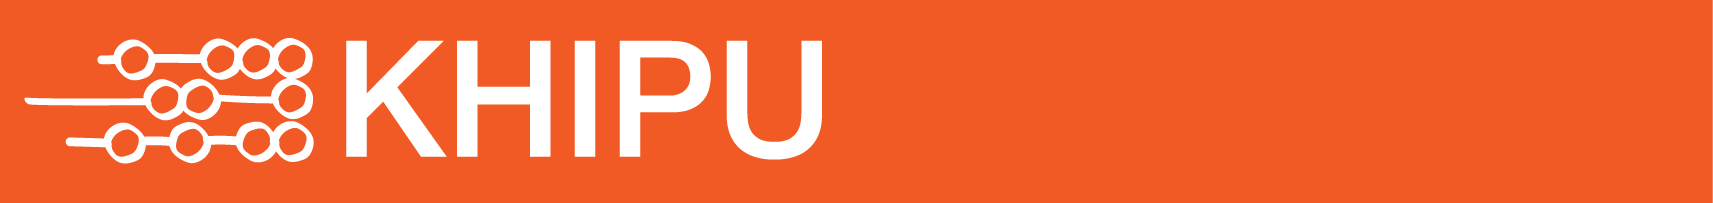